In [1]:
pip install rembg

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Remove background
from rembg import remove

In [3]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

# # Access the desired folder
# folder_path = '/content/drive/MyDrive/CSCI 6364'

In [4]:
# !unzip '/content/drive/MyDrive/CSCI 6364/ASL_data.zip'

In [5]:
# Configuration
class CFG:
    batch_size = 64
    img_height = 64
    img_width = 64
    epochs = 10
    num_classes = 29
    img_channels = 3

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [6]:
# Labels
TRAIN_PATH = "./Datasets/asl_data/asl_data_train"
labels = []
alphabet = list(string.ascii_uppercase)
numbers = [str(i) for i in range(10)]
labels.extend(alphabet)
labels.extend(numbers)
labels.extend(["Dont_like","Like","Baby","Brother","Friend","House","Help"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Dont_like', 'Like', 'Baby', 'Brother', 'Friend', 'House', 'Help']


In [7]:
def convert_jpeg_to_jpg_in_folders(root_path):
    for dir_path, _, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith('.jpeg'):
                # Construct the paths for jpeg and jpg files
                jpeg_path = os.path.join(dir_path, filename)
                jpg_path = os.path.join(dir_path, filename[:-5] + '.jpg')  # Change extension

                # Convert jpeg to jpg
                os.rename(jpeg_path, jpg_path)
                print(f"Converted {filename} to {filename[:-5]}.jpg")

# List of paths to traverse
paths = [
    "./Datasets/asl_data/asl_data_train",
    "./Datasets/asl_data/asl_data_test"
]

# Convert jpeg to jpg in each path
for path in paths:
    convert_jpeg_to_jpg_in_folders(path)


In [8]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

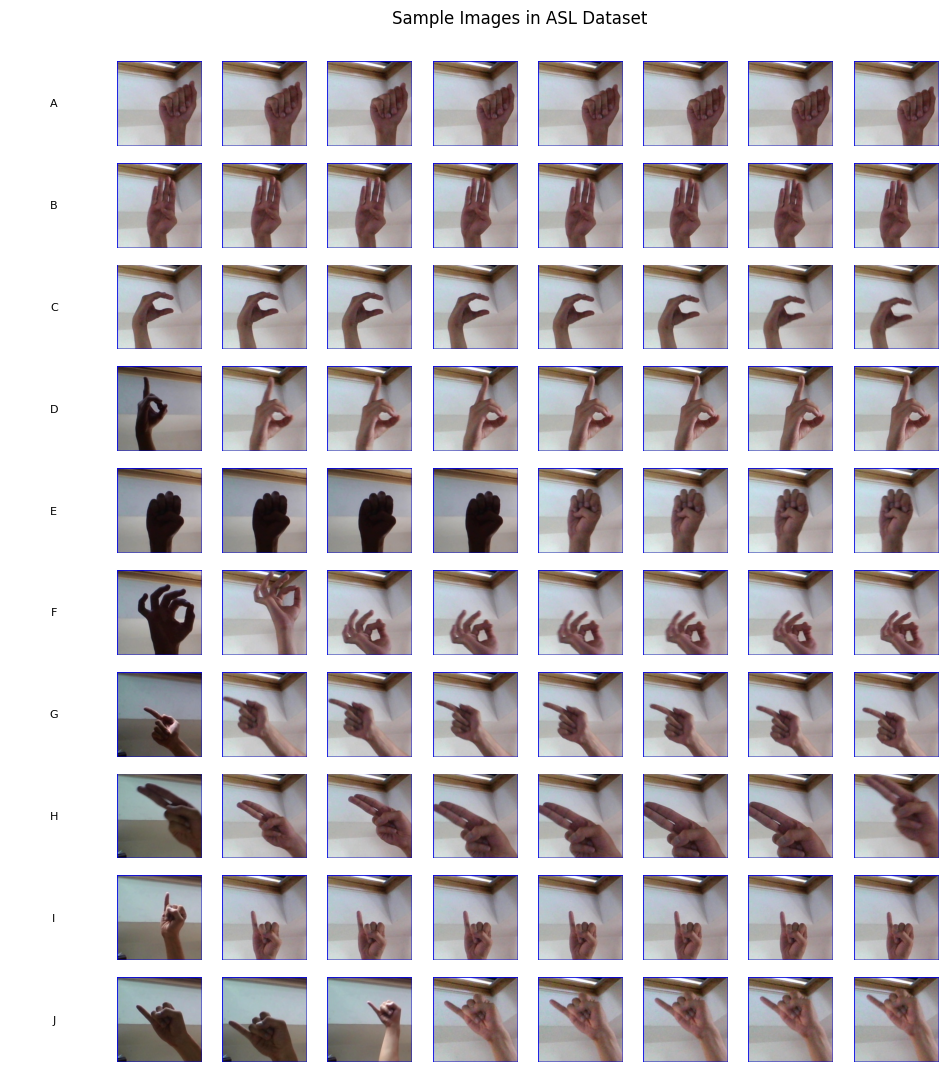

In [9]:
sample_images(labels[:10])

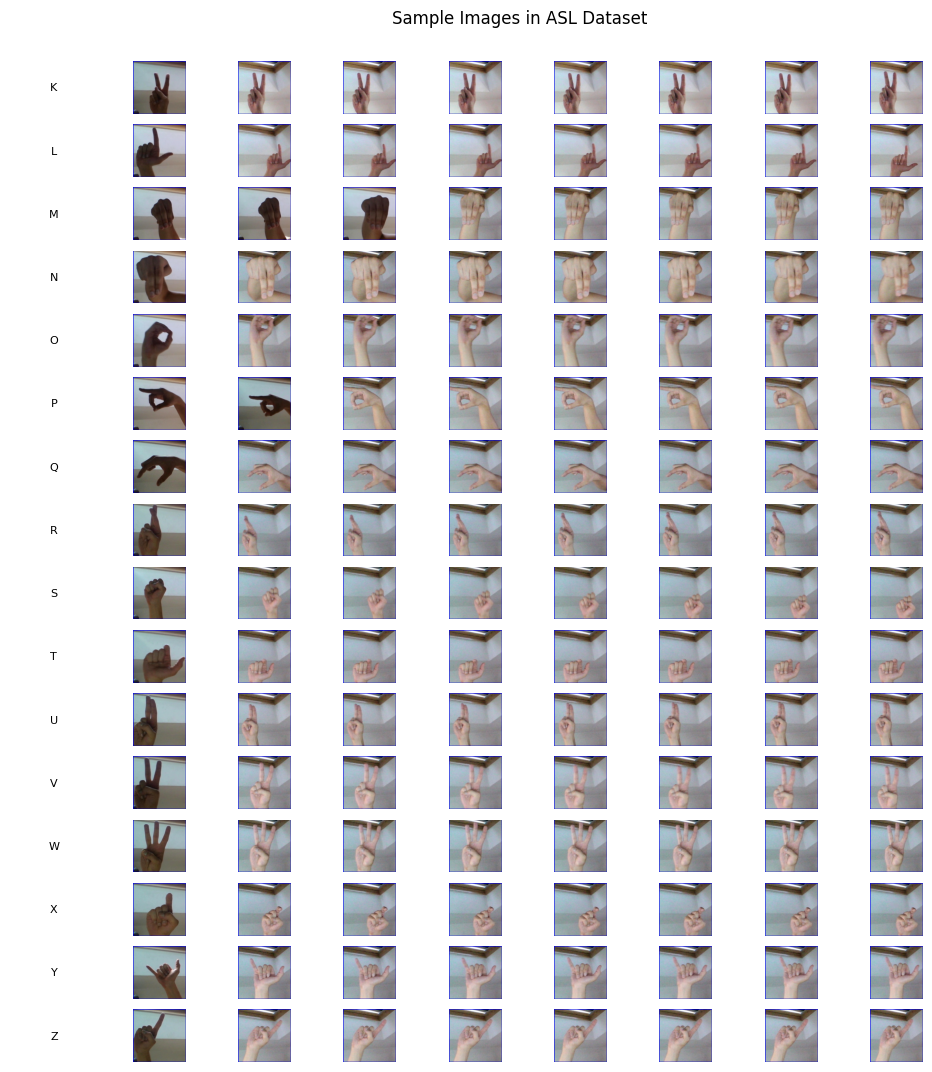

In [10]:
sample_images(labels[10:26])

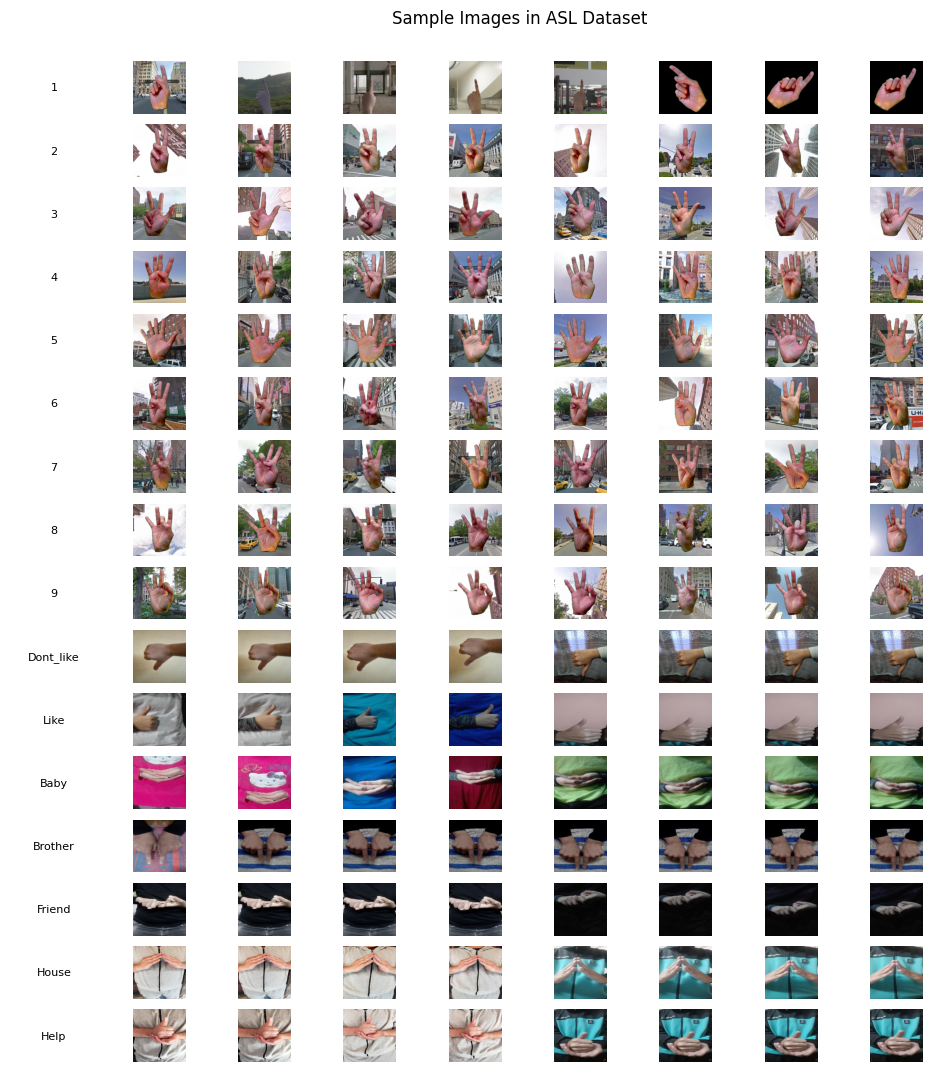

In [11]:
sample_images(labels[27:])

In [12]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

,image_path,label
0,./Datasets/asl_data/asl_data_train\A\A1001.jpg,A
1,./Datasets/asl_data/asl_data_train\A\A1002.jpg,A
2,./Datasets/asl_data/asl_data_train\A\A1003.jpg,A
3,./Datasets/asl_data/asl_data_train\A\A1004.jpg,A
4,./Datasets/asl_data/asl_data_train\A\A1005.jpg,A
...,...,...
64774,./Datasets/asl_data/asl_data_train\Help\Help_9...,Help
64775,./Datasets/asl_data/asl_data_train\Help\Help_9...,Help
64776,./Datasets/asl_data/asl_data_train\Help\Help_9...,Help
64777,./Datasets/asl_data/asl_data_train\Help\Help_9...,Help


In [13]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.15,
    random_state=2023,
    shuffle=True,
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=2023,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

,image_path,label
37183,./Datasets/asl_data/asl_data_train\Y\Y486.jpg,Y
26114,./Datasets/asl_data/asl_data_train\R\R202.jpg,R
2857,./Datasets/asl_data/asl_data_train\B\B606.jpg,B
54469,./Datasets/asl_data/asl_data_train\Dont_like\D...,Dont_like
3277,./Datasets/asl_data/asl_data_train\C\C1359.jpg,C
...,...,...
21890,./Datasets/asl_data/asl_data_train\O\O2489.jpg,O
12656,./Datasets/asl_data/asl_data_train\I\I2218.jpg,I
27677,./Datasets/asl_data/asl_data_train\S\S2126.jpg,S
536,./Datasets/asl_data/asl_data_train\A\A1537.jpg,A


,image_path,label
52556,./Datasets/asl_data/asl_data_train\9\149.png,9
36559,./Datasets/asl_data/asl_data_train\Y\Y1931.jpg,Y
22938,./Datasets/asl_data/asl_data_train\P\P1567.jpg,P
64379,./Datasets/asl_data/asl_data_train\Help\Help_6...,Help
29153,./Datasets/asl_data/asl_data_train\T\T209.jpg,T
...,...,...
28671,./Datasets/asl_data/asl_data_train\T\T1290.jpg,T
5406,./Datasets/asl_data/asl_data_train\D\D2041.jpg,D
5763,./Datasets/asl_data/asl_data_train\D\D400.jpg,D
7923,./Datasets/asl_data/asl_data_train\F\F1825.jpg,F


,image_path,label
58742,./Datasets/asl_data/asl_data_train\Baby\Baby_7...,Baby
49957,./Datasets/asl_data/asl_data_train\7\7 (1).jpg,7
1305,./Datasets/asl_data/asl_data_train\A\A2306.jpg,A
8139,./Datasets/asl_data/asl_data_train\F\F217.jpg,F
18844,./Datasets/asl_data/asl_data_train\M\M2545.jpg,M
...,...,...
7465,./Datasets/asl_data/asl_data_train\E\E908.jpg,E
61830,./Datasets/asl_data/asl_data_train\House\House...,House
30626,./Datasets/asl_data/asl_data_train\U\U2043.jpg,U
38817,./Datasets/asl_data/asl_data_train\Z\Z707.jpg,Z


In [14]:
path_train = './Datasets/asl_data/asl_data_train'
path_test = './Datasets/asl_data/asl_data_test'
target_size = (64,64)
target_dims = (64,64,3)
val_frac = 0.1
n_classes = 29
batch_size = 64

image_generator = ImageDataGenerator(samplewise_center = True, samplewise_std_normalization = True, validation_split=val_frac)

train_gen = image_generator.flow_from_directory(path_train, target_size=target_size, batch_size=batch_size, shuffle=True, subset='training')
val_gen = image_generator.flow_from_directory(path_train, target_size=target_size, subset='validation')

Found 58302 images belonging to 43 classes.
Found 6477 images belonging to 43 classes.


In [15]:
def convert_jpeg_to_jpg_in_folders(root_path):
    for dir_path, _, filenames in os.walk(root_path):
        for filename in filenames:
            if filename.endswith('.jpeg'):
                # Construct the paths for jpeg and jpg files
                jpeg_path = os.path.join(dir_path, filename)
                jpg_path = os.path.join(dir_path, filename[:-5] + '.jpg')  # Change extension

                # Convert jpeg to jpg
                os.rename(jpeg_path, jpg_path)
                print(f"Converted {filename} to {filename[:-5]}.jpg")

# List of paths to traverse
paths = [
    "./Datasets/asl_data/asl_data_train",
    "./Datasets/asl_data/asl_data_test"
]

# Convert jpeg to jpg in each path
for path in paths:
    convert_jpeg_to_jpg_in_folders(path)


In [16]:
direc=os.listdir('./Datasets/asl_data/asl_data_train/')
print(direc)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'Baby', 'Brother', 'C', 'D', 'Dont_like', 'E', 'F', 'Friend', 'G', 'H', 'Help', 'House', 'I', 'J', 'K', 'L', 'Like', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [17]:
def remove_background(input_path, output_path):
    input_image = Image.open(input_path)
    # Assuming `remove` function removes the background and returns an RGBA image
    # You can convert it to RGB mode before saving
    output_image = remove(input_image)
    # Convert RGBA image to RGB mode
    output_image = output_image.convert("RGB")
    output_image.save(output_path)

def process_images_in_directory(input_directory, output_directory):
    for root, dirs, files in os.walk(input_directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                input_path = os.path.join(root, file)
                output_path = os.path.join(output_directory, os.path.relpath(input_path, input_directory))
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                remove_background(input_path, output_path)

In [18]:
for i in direc[40:43]:
    path_train = './Datasets/asl_data/asl_data_train/{}'.format(i)
    output_train = './Datasets/asl_data_train_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [19]:
# path_test = './Datasets/asl_data/asl_data_test/'
# output_test = './Datasets/asl_data_test_processed'
# process_images_in_directory(path_test, output_test)

In [20]:
for i in direc[0:3]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [21]:
for i in direc[3:6]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [22]:
for i in direc[6:10]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [23]:
for i in direc[10:13]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [24]:
for i in direc[13:16]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [25]:
for i in direc[16:20]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [26]:
for i in direc[20:23]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [27]:
for i in direc[23:26]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [28]:
for i in direc[26:30]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [29]:
for i in direc[30:33]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [30]:
for i in direc[33:36]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [31]:
for i in direc[36:40]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)

In [32]:
for i in direc[40:43]:
    path_train = './Datasets/asl_data/asl_data_test/{}'.format(i)
    output_train = './Datasets/asl_data_test_processed/{}'.format(i)
    process_images_in_directory(path_train, output_train)